In [2]:
from signal import signal, SIGPIPE, SIG_DFL
signal(SIGPIPE, SIG_DFL) 

<Handlers.SIG_IGN: 1>

# Blind set
## General workflow
1. Select on PDB all structures meeting pre-defined criteria (experimental method, resolution, release, chain length, macromolecule type etc.)
2. Retrieve FASTA for all chains and run blastclust to reduce internal redundancy to 30% sequence identity and e.g. 50% of coverage
3. Using blastp, align the reduced preliminary set of protein chains to the JPred4 dataset (ask blastp to provide tabular output –outfmt 6)
4. Filter-out from the preliminary chain set, all chains having at least one BLAST hit with SI >=30% with any sequence in JPred4 dataset
5. Go back to the PDB list and isolate only those containing chains surviving the previous filtering step
6. Download structures from PDB
7. Generate DSSP files from selected PDB files
8. Extract SS strings from DSSP (only for chains selected at point 4)

### 1. Select on PDB all structures meeting pre-defined criteria
The structures will be retrieved from the Protein Data Bank (PDB) according to the following criteria:
- Deposit date after Jan, 2015 (JPred4 year of release is 2014)
- High-quality experimental data (X-ray crystals with resolution < 2.5Å)
- Chain length between 50 and 300 residues
- Only proteins, no RNA/DNA

The initial dataset from PDB counted of ```30000``` PDB structures that fulfilled the query. We downloaded the cvs files in batch (6 files). We then merge them in one file.

In [1]:
!cat ./dataset/rcsb_pdb_custom_report_94474e262632e51b2ee575eee4d4c4c2_00001-05000.csv ./dataset/rcsb_pdb_custom_report_94474e262632e51b2ee575eee4d4c4c2_05001-10000.csv ./dataset/rcsb_pdb_custom_report_94474e262632e51b2ee575eee4d4c4c2_10001-15000.csv ./dataset/rcsb_pdb_custom_report_94474e262632e51b2ee575eee4d4c4c2_15001-20000.csv ./dataset/rcsb_pdb_custom_report_94474e262632e51b2ee575eee4d4c4c2_20001-25000.csv ./dataset/rcsb_pdb_custom_report_94474e262632e51b2ee575eee4d4c4c2_20001-25000.csv > ./dataset/initial_dataset.csv

let's inspect our final file.

In [2]:
!wc ./dataset/initial_dataset.csv -l
!head ./dataset/initial_dataset.csv

30006 ./dataset/initial_dataset.csv
"Entity ID","PDB ID","Sequence","Entity Polymer Type","Chain Length","Chain ID",
"6IBE_1","6IBE","SMPKSMQCKVILLDGSEYTCDVEKRSRGQVLFDKVCEHLNLLEKDYFGLTYRDAENQKNWLDPAKEIKKQVRSGAWHFSFNVKFYPPDPAQLSEDITRYYLCLQLRDDIVSGRLPCSFVTLALLGSYTVQSELGDYDPDECGSDYISEFRFAPNHTKELEDKVIELHKSHRGMTPAEAEMHFLENAKKLSMYGVDLHHAKDSEGVEIMLGVCASGLLIYRDRLRINRFAWPKVLKISYKRNNFYIKIRPGEFEQFESTIGFKLPNHRAAKRLWKVCVEHHTFFRLL","Protein",286,"A",
"5PFT_1","5PFT","MHHHHHHSSGVDLGTENLYFQSMSVKKPKRDDSKDLALCSMILTEMETHEDAWPFLLPVNLKLVPGYKKVIKKPMDFSTIREKLSSGQYPNLETFALDVRLVFDNCETFNEDDSDIGRAGHNMRKYFEKKWTDTFKVS","Protein",138,"A",
"5PG5_1","5PG5","MHHHHHHSSGVDLGTENLYFQSMSVKKPKRDDSKDLALCSMILTEMETHEDAWPFLLPVNLKLVPGYKKVIKKPMDFSTIREKLSSGQYPNLETFALDVRLVFDNCETFNEDDSDIGRAGHNMRKYFEKKWTDTFKVS","Protein",138,"A",
"5PXH_1","5PXH","ENSNICEVCNKWGRLFCCDTCPRSFHEHCHIPSVEANKNPWSCIFCRIKTIQERCPESQSGHQESEVLMRQMLPEEQLKCEFLLLKVYCDSKSCFFASEPYYNREGSQGPQKPMWLNKVKTSLNEQMYTRVEGFVQDMRLIFHNHKEFYREDKFTRLGIQVQDIFEKNFRNIFAIQETSK","Protein

Every files has an header of ```"Entity ID","PDB ID","Sequence","Entity Polymer Type","Chain Length","Chain ID"``` therefore we will find 5 additional lines that we will delete in the next step.

In [36]:
import pandas as pd
import Bio

df = pd.read_csv('./dataset/initial_dataset.csv')  # reading the final .csv
df = df.sort_values('Chain Length')   # sorting value by chain to have last rows the header
df = df[:30000]    # removing header rows

df.astype({'Chain Length': 'int32'}).dtypes  # checking datatypes

Entity ID               object
PDB ID                  object
Sequence                object
Entity Polymer Type     object
Chain Length             int32
Chain ID                object
Unnamed: 6             float64
dtype: object

The final dataframe will be as:

In [24]:
df

,Entity ID,PDB ID,Sequence,Entity Polymer Type,Chain Length,Chain ID,Unnamed: 6
12580,6TDS_2,6TDS,MIQRTPKIQVYSRHPAENGKSNFLNCYVSGFHPSDIEVDLLKNGER...,Protein,100,"B, D",NaN
22202,6RKG_1,6RKG,MHLNPAEKEKLQIFLASELALKRKARGLKLNYPEAVAIITSFIMEG...,Protein,100,A,NaN
9994,6D78_2,6D78,MIQRTPKIQVYSRHPAENGKSNFLNCYVSGFHPSDIEVDLLKNGER...,Protein,100,B,NaN
1087,5EOT_2,5EOT,MIQRTPKIQVYSRHPAENGKSNFLNCYVSGFHPSDIEVDLLKNGER...,Protein,100,B,NaN
26739,6PTE_2,6PTE,MIQRTPKIQVYSRHPAENGKSNFLNCYVSGFHPSDIEVDLLKNGER...,Protein,100,"B, F, I, L",NaN
...,...,...,...,...,...,...,...
22264,6PTP_1,6PTP,PQITLWKRPLVTIKIGGQLKEALLDTGADDTIIEEMSLPGRWKPKM...,Protein,99,"A, B",NaN
16418,6DIF_1,6DIF,PQITLWKRPLVTIKIGGQLKEALLDTGADDTVIEEMSLPGRWKPKM...,Protein,99,"A, B",NaN
3509,6OXX_1,6OXX,PQITLWKRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,Protein,99,"A, B",NaN
22312,5UPZ_1,5UPZ,PQITLWKRPLVTIKIGGQLKEALLDTGADDTVIEEMSLPGRWKPKM...,Protein,99,"A, B",NaN


Final sequence count: ```30000```

In [29]:
with open('cleanseq.fasta', 'w') as f_o:
    
    # we iterate into the dataframe taking into account the chainID, the pdbID and the sequence column
    # in this way we will build our final fasta file
    for chainID, pdbID, seq in zip(df['Chain ID'], df['PDB ID'], df['Sequence']):  
        ids = chainID.replace(' ', '').split(',')
        
        # we add a condition which states that whichever sequence contains more than 2 'X' will be discarded
        if seq.count('X')<=2:
            string = '>' + pdbID + ':' + ids[0]
            string.replace(' ', '')
            
            ## printing the actual fasta file
            f_o.write(string + '\n' + seq + '\n')
    

In [30]:
!grep '>' cleanseq.fasta | wc

  29985   29985  240395


```29985``` is the total number of fasta sequence in our initial dataset.

### 2. Reducing internal redundancy
now we need to reduce the redundancy to 30% Seq. Identity, to do so we will use ```mmhseq2```. why? /bisogna argomentare/

In [160]:
!mmseqs createdb cleanseq.fasta ./database_clust/DB
!mkdir tmp
!mmseqs cluster ./database_clust/DB ./database_clust/clu tmp --min-seq-id 0.3 -c 0.5 --cov-mode 0

createdb cleanseq.fasta ./database_clust/DB 

MMseqs Version:       	12.113e3
Database type         	0
Shuffle input database	true
Createdb mode         	0
Write lookup file     	1
Offset of numeric ids 	0
Compressed            	0
Verbosity             	3

Converting sequences
[29897] 0s 74ms
Time for merging to DB_h: 0h 0m 0s 9ms
Time for merging to DB: 0h 0m 0s 15ms
Database type: Aminoacid
Time for processing: 0h 0m 0s 206ms
cluster ./database_clust/DB ./database_clust/clu tmp --min-seq-id 0.3 -c 0.5 --cov-mode 0 

MMseqs Version:                     	12.113e3
Substitution matrix                 	nucl:nucleotide.out,aa:blosum62.out
Seed substitution matrix            	nucl:nucleotide.out,aa:VTML80.out
Sensitivity                         	4
k-mer length                        	0
k-score                             	2147483647
Alphabet size                       	nucl:5,aa:21
Max sequence length                 	65535
Max results per query               	20
Split database             

In [161]:
!mmseqs createsubdb ./database_clust/clu ./database_clust/DB ./database_clust/DB_clu_rep
!mmseqs convert2fasta ./database_clust/DB_clu_rep DB_clu_rep.fasta   

createsubdb ./database_clust/clu ./database_clust/DB ./database_clust/DB_clu_rep 

MMseqs Version:	12.113e3
Subdb mode	0
Verbosity 	3

Time for merging to DB_clu_rep: 0h 0m 0s 0ms
Time for processing: 0h 0m 0s 5ms
convert2fasta ./database_clust/DB_clu_rep DB_clu_rep.fasta 

MMseqs Version:	12.113e3
Use header DB	false
Verbosity    	3

Start writing file to DB_clu_rep.fasta
Time for processing: 0h 0m 0s 9ms


In [163]:
!grep '>' DB_clu_rep.fasta | wc -l 

4274


The final internal clusterization output ```4271``` clusters.

### 3. Reducing external redundancy w.r.t. JPred4



To reduce the external redundancy we use ```blastp```. Before using this tool we need to make our dataset in fasta a DB.

we use the following from the ```../fasta/``` directory:

```for FILE in *; do cat $FILE >> ../jpre.fasta; done```

Let's check if the sequences are the right number and we did not forget anything behind. They should be ```1348```

In [164]:
!grep '>' jpre.fasta | wc -l

1348


In [165]:
!makeblastdb -in jpre.fasta -dbtype prot



Building a new DB, current time: 09/19/2020 18:41:45
New DB name:   /home/fecke/PycharmProjects/lb2-2020-project-brando/jpre.fasta
New DB title:  jpre.fasta
Sequence type: Protein
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 1348 sequences in 0.0661218 seconds.


In [166]:
!blastp -query DB_clu_rep.fasta -db ../jpre.fasta -evalue 0.01 -out hits.blast.tab -outfmt 6

In [167]:
!head hits.blast.tab | sort -nk 3

6ICE:A	d3b64a_	27.711	83	58	1	32	114	32	112	2.87e-09	46.2
6KMB:A	d3jvla_	28.333	60	43	0	42	101	46	105	0.007	28.9
6GMP:A	d3ui4a_	33.333	63	35	2	62	118	34	95	5.77e-04	32.0
6L2A:A	d1m1fa_	37.079	89	48	4	6	94	1	81	1.74e-06	38.9
6IP9:A	d2vb1a_	41.593	113	62	3	3	111	3	115	4.75e-27	92.4
5MR9:A	d2aska_	48.515	101	48	2	5	102	1	100	1.81e-22	79.0
6S5P:A	d2bv4a_	60.526	114	44	1	2	115	1	113	5.34e-46	139
6DGK:A	d3rvca_	96.610	118	4	0	1	118	1	118	3.24e-83	234
6RP1:A	d4ac7a_	98.000	100	2	0	1	100	1	100	6.31e-71	201
6IC6:A	d3pdfa1	100.000	118	0	0	1	118	1	118	1.87e-88	247


The third column express the sequence identity percentage, we will then sort the column and take into consideration only those sequences in our cluster that have less than 30% S.I.

In [168]:
!wc hits.blast.tab

  871 10452 49080 hits.blast.tab


In [169]:
!awk '{if ($3 > 30) print $1}'  hits.blast.tab > morethan30SI.ids

In [171]:
!wc morethan30SI.ids 

 649  649 4562 morethan30SI.ids


In [172]:
#!/usr/bin/env python3

from Bio import SeqIO

def list_ids(id_path):
    """
    Return a set containing the identifiers presented in a file,
    line by line, starting with ">"
    """

    # read the first file given and generate a set (faster iteration respect lists

    identifiers = set([])

    with open(id_path, 'r') as fi:
        for line in fi:
            line = line.strip()
            identifiers.add(str(line).replace(">", ""))

    return identifiers

def filter(id_path, origin_fasta, final_fasta):
    """
    Writes a file containing only the sequences with identifiers NOT
    present in a set of identifiers
    """

    identifiers = list_ids(id_path)

    with open(origin_fasta) as original_fasta, open(final_fasta, 'w') as corrected_fasta:
        records = SeqIO.parse(original_fasta, 'fasta')
        for record in records:
            # print(record.id)
            if record.id not in identifiers:
                SeqIO.write(record, corrected_fasta, 'fasta')

if __name__ == '__main__':
    filter('morethan30SI.ids', 'DB_clu_rep.fasta', 'corrected_cluster.fasta')

6RP1:A
5HHD:E
5MR9:A
6E2J:B
6HC0:B
6W3W:A
5D4N:A
6IMF:B
5HS7:A
6YUD:A
5OYM:A
6KMB:A
6S5P:A
6U52:B
6I7R:B
6IC6:A
6DGK:A
6DXH:A
6JDG:A
6GMP:A
6L2A:A
6IP9:A
6P1E:A
5F3M:A
6ICE:A
5BPV:A
5OGH:A
5VEB:X
5C6X:A
6I4M:G
5HBO:A
5Y0C:D
5TZU:C
6BS9:A
5HSF:A
5ELK:A
6GAK:A
6W1T:U
5VMY:A
5IT6:A
5HI8:A
5CHQ:A
5C5Z:A
5GIT:A
5V6K:A
5C9F:A
6ILU:A
6MYT:C
6DP8:A
5C5M:A
6WIH:D
5J7E:A
6XBQ:A
5Y6G:A
5B1B:D
5HLI:A
5NV2:A
6IBI:A
5CPG:A
6QAI:A
5F48:A
4YVQ:C
4S2W:A
6KI2:A
6W1Q:V
4YG0:A
6HF6:A
5AP8:A
5QON:A
6QZU:A
6GCD:A
5DJO:A
6JSD:A
5I93:A
5LZK:A
6NWJ:A
6CWF:A
5Y3Z:A
6SZY:A
5YL6:A
6DRQ:A
5BQ5:A
6K1Y:A
5QNL:A
5HKL:A
6KO8:A
4Z9H:A
4ZFR:A
5R4S:A
5UQI:A
5XJ8:A
6BT4:A
5XGR:A
5MM8:A
6YPE:A
5SW0:A
6RGX:A
5A4A:A
5E46:A
6PJ4:A
5OW5:A
5U7B:A
6QW0:A
6OAE:A
5LF3:M
5XO1:A
4YLQ:T
5Z48:A
6HS1:A
6BTD:A
5WL5:A
5BOC:A
5X1B:B
5KO7:A
6HO9:A
6CJL:A
7JMP:A
6TV1:A
5UM0:A
6CVF:A
5JEF:A
5KEC:A
5ZYM:A
6EXL:A
6I64:A
6QOC:A
6VIJ:A
5TTA:A
5MZZ:B
5BSZ:A
5CL2:A
6PCU:B
6W3X:A
6D3V:A
5DGX:A
5G1T:A
6MWA:B
5R0Y:A
4XT5:A
6UEG:A
4XHF:A
5LL5:A
6C7M:A

In [173]:
!grep '>' DB_clu_rep.fasta | wc

   4274    4274   34278


In [174]:
!grep '>' corrected_cluster.fasta | wc

   3697    3697   29645


### 4. Randomly chose 150 sequences from the cluster

```!grep '>' corrected_cluster.fasta | sort -R | head -150 > blindset.ids```

In [179]:
!wc blindset.ids

 150  150 1200 blindset.ids


### 5. Running DSSP

In [176]:
!cat blindset.ids | sed 's/[>:]/ /g' | awk '{print $1}' | while read line;do wget -nv https://files.rcsb.org/download/$line.pdb; done

2020-09-19 18:44:07 URL:https://files.rcsb.org/download/6GCD.pdb [358830] -> "6GCD.pdb" [1]
2020-09-19 18:44:12 URL:https://files.rcsb.org/download/5ED0.pdb [2325915] -> "5ED0.pdb" [1]
2020-09-19 18:44:14 URL:https://files.rcsb.org/download/5V89.pdb [573885] -> "5V89.pdb" [1]
2020-09-19 18:44:15 URL:https://files.rcsb.org/download/6J05.pdb [301725] -> "6J05.pdb" [1]
2020-09-19 18:44:18 URL:https://files.rcsb.org/download/6W2R.pdb [1416285] -> "6W2R.pdb" [1]
2020-09-19 18:44:20 URL:https://files.rcsb.org/download/6RRV.pdb [350001] -> "6RRV.pdb" [1]
2020-09-19 18:44:22 URL:https://files.rcsb.org/download/5T9B.pdb [384993] -> "5T9B.pdb" [1]
2020-09-19 18:44:24 URL:https://files.rcsb.org/download/6UB7.pdb [214407] -> "6UB7.pdb" [1]
2020-09-19 18:44:26 URL:https://files.rcsb.org/download/6LQF.pdb [378513] -> "6LQF.pdb" [1]
2020-09-19 18:44:28 URL:https://files.rcsb.org/download/5CHL.pdb [206874] -> "5CHL.pdb" [1]
2020-09-19 18:44:30 URL:https://files.rcsb.org/download/6EQH.pdb [612441] -> "

In [5]:
!for FILE in pdb_blindset/*;do echo $FILE; done | wc

    150     150    3300


In [4]:
!for file in $(ls ./pdb_blindset);do mkdssp -i ./pdb_blindset/$file -o dssp_150/${file:0:-4}.dssp;done

### 6. Extracting dssp chain

In [1]:
!sort blindset.ids | sed 's/>//g'  > sort_blindset.ids

In [24]:
import os
import re

f_id = open('sort_blindset.ids', 'r')

c = 0
f_dssp = []

for filename in sorted(os.listdir('./dssp_150')):
    if filename.endswith('.dssp'): 
        f_dssp.append('dssp_150/'+ filename)
        
final = []

for filename, ID in zip(f_dssp, f_id):
    with open(filename) as f_ss:
        name, chain = ID.rstrip().split(':')
        #print(filename,name)
        for i, line in enumerate(f_ss):
            if i == 27:
                lines = f_ss.readlines()
                ss_str = ''
                aa_str = ''
                for l in lines:
                    if l[11] == chain:
                        ss_str += l[16]
                        aa_str += l[13]
                        if l[13] == '!' and l[14] != '*' and l[11] == ' ':
                            ss_str += '-'
                            aa_str += 'X'
                        elif l[14] == '*':
                            break
                # ss_str = ss_str.replace(' ','-')
                ss_str = re.sub('[G,I]', 'H', ss_str)
                ss_str = re.sub('[T,c,S,\ ]', '-', ss_str)
                ss_str = re.sub('B', 'E', ss_str)
                aa_str = re.sub('a', 'C', aa_str)
                final.append(['>'+ID, ss_str,aa_str])
                c += 1 
            
#for i in range(150):
#    if len(final[i][1]) < 50:
#        print(len(final[i][1]), final[i][0])

def do_file(namefile, lines, extension):
    namefile = './blindset_'+extension+'/'+namefile+'.'+extension
    with open(namefile, 'w') as output:
        output.write(lines)
        
for seq in final:
    dssp = ''.join(seq[:2])
    fasta = ''.join(seq[::2])
    #print(seq[0][1:5])
    do_file(seq[0][1:5], dssp, 'dssp')
    do_file(seq[0][1:5], fasta, 'fasta')

In [41]:
d = {}

for filename in os.listdir('blindset_dssp/'):
    if filename.endswith('.dssp'):
        filename = 'blindset_dssp/'+filename
        f = open(filename)
        for line in f:
            if '>' not in line:
                for char in line.rstrip():
                    d[char] = d.get(char,0)+1
        f.close()

In [42]:
ss_df = pd.DataFrame(d.items(), columns=['ss', 'count'])
ss_df = ss_df.set_index('ss')

<AxesSubplot:ylabel='count'>

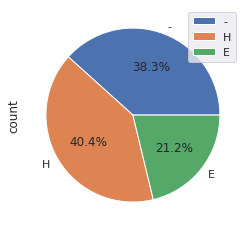

In [43]:
import seaborn as sn
sn.set()
ss_df.plot.pie(y="count", autopct='%1.1f%%')

### 6. PSIBLAST

In [25]:
!mkdir psiblast_output

In [26]:
!makeblastdb -in uniprot_sprot.fasta -dbtype prot



Building a new DB, current time: 09/24/2020 16:15:23
New DB name:   /home/fecke/PycharmProjects/lb2-2020-project-brando/uniprot_sprot.fasta
New DB title:  uniprot_sprot.fasta
Sequence type: Protein
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 563082 sequences in 33.7172 seconds.


In [32]:
!for file in $(ls ./blindset_fasta);do psiblast -query ./blindset_fasta/$file -db uniprot_sprot.fasta -evalue 0.01 \
-num_iterations 3 -out_ascii_pssm ${file:0:-6}.pssm -num_descriptions 10000 -num_alignments 10000 -out ${file:0:-6}.alns.blast ;done

In [2]:
!python ../script/pssmparse.py ./psiblast_output/